# Evaluation of TSP Solvers

In [1]:
!pip install python_tsp
!pip install fast-tsp

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Import Relevant Libraries

In [2]:
from gettext import install

import sys
import os
import time

import numpy as np
import pandas as pd

# Import from matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Import from scipy
from scipy.spatial import distance_matrix
# from scipy.optimize import linprog

# Import from python-tsp
from python_tsp.exact import solve_tsp_dynamic_programming as dynamic_programming

## Testing using a randomly generated distance matrix

### Creating the matrix

In [3]:
def generate_random_points(n, seed=None):
    np.random.seed(seed)
    return np.random.rand(n, 2)*1000

In [4]:
test = generate_random_points(10, seed=42)
print(test)

[[374.54011885 950.71430641]
 [731.99394181 598.6584842 ]
 [156.01864044 155.99452034]
 [ 58.08361217 866.17614577]
 [601.11501174 708.0725778 ]
 [ 20.5844943  969.90985216]
 [832.4426408  212.33911068]
 [181.82496721 183.40450985]
 [304.24224296 524.75643163]
 [431.94501864 291.2291402 ]]


In [5]:
def generate_distance_matrix(points):
    return distance_matrix(points, points)

In [6]:
dist = generate_distance_matrix(test)
print(dist)

[[   0.          501.71360108  824.21549057  327.55369212  331.98070811
   354.47574406  868.83407466  791.1406029   431.71970356  661.97885689]
 [ 501.71360108    0.          726.42889032  725.06608779  170.58938482
   802.45310158  399.16487757  689.29076871  434.0887343   429.58370296]
 [ 824.21549057  726.42889032    0.          716.90251142  709.15510382
   825.10640243  678.7666323    37.64670007  397.43626353  307.28450757]
 [ 327.55369212  725.06608779  716.90251142    0.          565.57920677
   110.30351618 1013.47657777  693.89410559  420.90556271  685.81076871]
 [ 331.98070811  170.58938482  709.15510382  565.57920677    0.
   636.84726578  547.05040205  671.62543353  348.91008912  449.8632437 ]
 [ 354.47574406  802.45310158  825.10640243  110.30351618  636.84726578
     0.         1110.41752436  802.86309143  527.84778695  793.61513959]
 [ 868.83407466  399.16487757  678.7666323  1013.47657777  547.05040205
  1110.41752436    0.          651.26075294  613.67763745  408.193

### Using Dynamic Programming

In [7]:
def dynamic_prog(dist):
    if len(dist) >= 20:
        print("The number of points is too large for dynamic programming.")
        return None, None
    
    result = dynamic_programming(dist)
    
    # Return back to depot
    result[0].append(0)
    return result

result = dynamic_prog(dist)
print(result[0], result[1])

[0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0] 2903.067737777875


### Using Christofides

In [8]:
class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)
    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):
    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

In [9]:
# https://github.com/Retsediv/ChristofidesAlgorithm
from collections import defaultdict

def christofides(dist):
    # build a graph
    G = defaultdict(dict)
    # print("Graph: ", G)

    for i in range(len(dist)):
        for j in range(len(dist[i])):
            if i != j:
                G[i][j] = dist[i][j]

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    # print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    # print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    # print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0
    
    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    # print("Result path: ", path)
    # print("Result length of the path: ", length)

    return path, length

### Using Greedy

In [10]:
import fast_tsp

def greedy(dist):
    pairwise_dist = (dist * 1000).astype(int)
    tour = fast_tsp.greedy_nearest_neighbor(pairwise_dist)

    # Need to return back to depot
    tour.append(0)
    
    total_dist = 0
    for i in range(len(tour)-1):
        total_dist += dist[tour[i], tour[i+1]]
    return tour, total_dist

### Using OR-Tools

In [11]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

class ORTools:
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        self.manager = pywrapcp.RoutingIndexManager(len(self.dist_matrix), 1, 0)
        self.routing = pywrapcp.RoutingModel(self.manager)
        self.solution = self.solve()

    def distance_callback(self, from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        distance_matrix = self.dist_matrix.astype(int)

        return distance_matrix[from_node][to_node]
    
    def solve(self):
        transit_callback_index = self.routing.RegisterTransitCallback(self.distance_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        self.search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        self.search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        solution = self.routing.SolveWithParameters(self.search_parameters)
        return solution
        
    def print_solution(self):
        index = self.routing.Start(0)
        # plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        route = []

        while not self.routing.IsEnd(index):
            # plan_output += f" {self.manager.IndexToNode(index)} ->"
            route.append(self.manager.IndexToNode(index))
            previous_index = index
            index = self.solution.Value(self.routing.NextVar(index))
            # route_distance += self.routing.GetArcCostForVehicle(previous_index, index, 0)
            # print(previous_index, index)
            if index == len(self.dist_matrix):
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(0)]
            else:
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(index)]

        # Return back to depot
        route.append(self.manager.IndexToNode(0))
        
        # plan_output += f" {self.manager.IndexToNode(index)}\n"
        # plan_output += f"Route distance: {route_distance}\n"
        # print(plan_output)
        
        # print(route_distance)
        return route, route_distance
        

In [12]:
def or_tools(distance_matrix):
    # Create the routing index manager.
    ortool = ORTools(distance_matrix)
    return ortool.print_solution()

### Final Output

In [13]:
def evaluate(solvers, distance_matrix, instance_name=None, num_dests=None):
    # Input arguments: 
    # solvers - dict(name: str, solver: function)
    # distance_matrix - n-by-n matrix containing pairwise distances
    # instance_name - name of the instance
    # num_dests - number of destinations to visit

    if num_dests is None:
        num_dests = len(distance_matrix) - 1

    results = {}
    for name, solver in solvers.items():
        start = time.time_ns()
        result = solver(distance_matrix)
        end = time.time_ns()

        results[name] = {
            'instance': instance_name,
            'sequence': result[0],
            'distance (m)': result[1],
            'time (ns)': end - start,
            'num_dests': num_dests
        }

    # print(results)
    # result = {"name_of_solver": {"result": order of seq,
    #                              "distance": distance travelled.
    #                              "time": time taken to find a solution}}
    return results


def plot_points(points, tour=None):
    plt.scatter(points[:, 0], points[:, 1])
    if tour is not None:
        for i in range(len(tour)):
            plt.plot([points[tour[i-1], 0], points[tour[i], 0]], [points[tour[i-1], 1], points[tour[i], 1]], 'r-')
    plt.show()


def plot_results(points, results, distance_matrix):
    plot_points(points)
    
    print(results)

    for name, result in results.items():
        tour = result['sequence']
        if tour is not None:
            plot_points(points, tour)
            print(f'{name} - Length: {sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1))}')

        else:
            print(f'{name} - No solution found')
        print(f'{name} - Time: {result["time (ns)"]} ns\n')

The number of points is too large for dynamic programming.


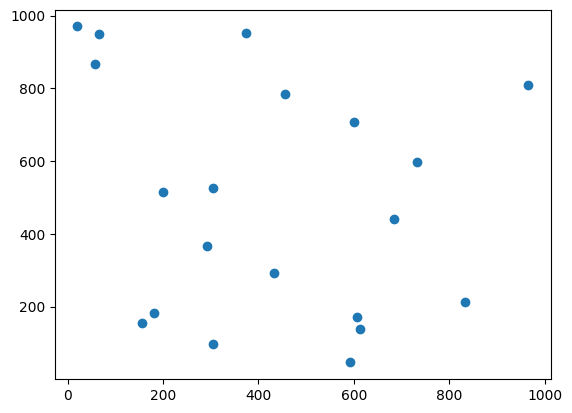

{'Greedy': {'instance': None, 'sequence': [0, 12, 4, 1, 19, 6, 15, 10, 14, 18, 7, 2, 11, 9, 8, 13, 3, 16, 5, 17, 0], 'distance (m)': 4650.384155596448, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': None, 'sequence': [15, 10, 14, 9, 11, 8, 13, 7, 2, 18, 5, 16, 3, 0, 12, 4, 1, 17, 19, 6, 15], 'distance (m)': 4544.71992552399, 'time (ns)': 0, 'num_dests': 19}, 'OR Tools': {'instance': None, 'sequence': [0, 16, 5, 3, 13, 8, 11, 9, 7, 2, 18, 14, 10, 15, 6, 19, 1, 17, 4, 12, 0], 'distance (m)': 3866.266770061002, 'time (ns)': 9509600, 'num_dests': 19}, 'Dynamic Programming': {'instance': None, 'sequence': None, 'distance (m)': None, 'time (ns)': 0, 'num_dests': 19}}


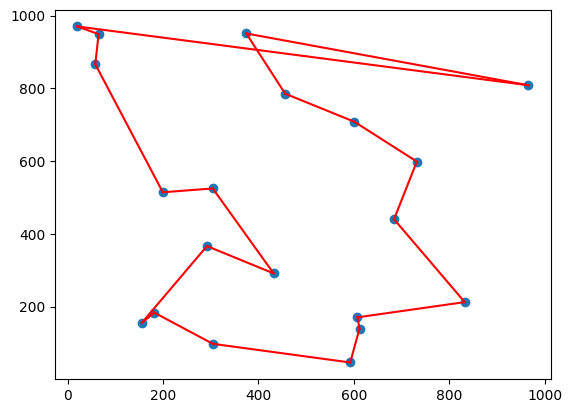

Greedy - Length: 4650.384155596448
Greedy - Time: 0 ns



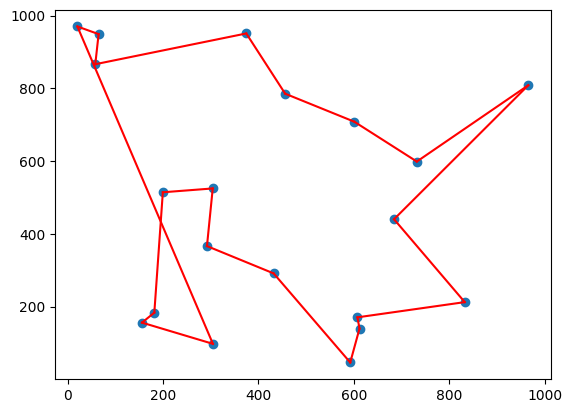

Christofides - Length: 4544.71992552399
Christofides - Time: 0 ns



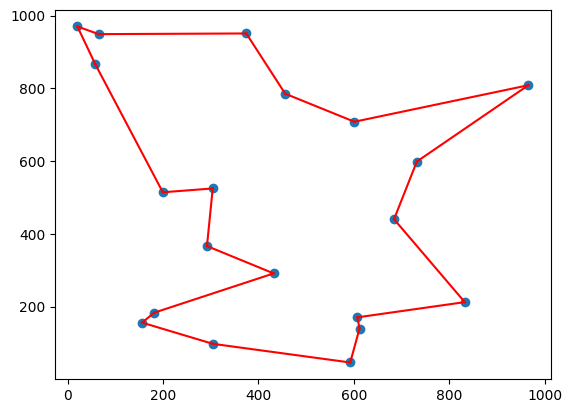

OR Tools - Length: 3866.266770061002
OR Tools - Time: 9509600 ns

Dynamic Programming - No solution found
Dynamic Programming - Time: 0 ns



In [14]:
def main():
    n = 20
    seed = 42
    sample_points = generate_random_points(n, seed)
    distance_matrix = generate_distance_matrix(sample_points)

    solvers = {
        'Greedy': greedy,
        'Christofides': christofides,
        'OR Tools': or_tools,
        'Dynamic Programming': dynamic_prog,
    }

    results = evaluate(solvers, distance_matrix)

    plot_results(sample_points, results, distance_matrix)

main()

## Executing Solvers on all Problem Instances

In [15]:
from pathlib import Path
import glob
from tqdm.notebook import tqdm

In [16]:
res = glob.glob("../processed_heuristic-threshold/instances/1/*/*")
print(res)

['../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1003_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1005_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1008_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1014_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1015_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1019_courier_1520', '../processed_heuristic-threshold/instances/1\\1\\ds_1020_courier_1558', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_87', '../processed_heuristic-threshold/instances/1\\1\\ds_1022_c

In [17]:
def run_solvers(file_path, solvers):
    path = Path(file_path)
    print(path)
    
    result = None
    if path.is_dir():
    
        with np.load(path / 'pairwise.npz') as data:
            dist_matrix = data["arr_0"]

        num_dest = dist_matrix.shape[0] - 1

        result = evaluate(solvers, dist_matrix, path.name, num_dests=num_dest)
        print(result, end="\n\n")

    return result

In [18]:
def generate_solver_df(file_paths):
    solvers = {
    'Greedy': greedy,
    'Christofides': christofides,
    'OR Tools': or_tools,
    # 'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            elif key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    greedy_df = pd.DataFrame(greedy_results)
    christofides_df = pd.DataFrame(christofides_results)
    or_tools_df = pd.DataFrame(or_tools_results)
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    greedy_df.to_csv("greedy_results.csv", index=False)
    christofides_df.to_csv("christofides_results.csv", index=False)
    or_tools_df.to_csv("or_tools_results.csv", index=False)
    dynamic_prog_df.to_csv("dynamic_prog_results.csv", index=False)

    return greedy_df, christofides_df, or_tools_df, dynamic_prog_df
    

In [19]:
# generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 1001500, 'num_dests': 1}}

{'Greedy': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'Christofides': {'instance': 'ds_1002_courier_218', 'sequence': [1, 0, 1], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}, 'OR Tools': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 1001500, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Greedy': {'

(                 instance                           sequence  distance (m)  \
 0     ds_1002_courier_218                          [0, 1, 0]   7438.872931   
 1     ds_1002_courier_967                          [0, 1, 0]  25531.317263   
 2     ds_1003_courier_218                          [0, 1, 0]     51.357485   
 3     ds_1005_courier_218                          [0, 1, 0]     44.871429   
 4     ds_1007_courier_218                          [0, 1, 0]     33.865249   
 ...                   ...                                ...           ...   
 1487  ds_910_courier_1558  [0, 5, 4, 1, 2, 3, 6, 7, 8, 9, 0]   8089.747437   
 1488   ds_919_courier_487  [0, 3, 4, 5, 6, 1, 9, 2, 7, 8, 0]  17477.600058   
 1489  ds_920_courier_1656  [0, 3, 4, 5, 2, 8, 6, 7, 9, 1, 0]  20958.354404   
 1490   ds_920_courier_487  [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0]  17844.073068   
 1491   ds_926_courier_487  [0, 8, 7, 6, 4, 5, 2, 9, 1, 3, 0]  17937.683222   
 
       time (ns)  num_dests  
 0             0    

In [20]:
def generate_solver_df(file_paths):
    solvers = {
    # 'Greedy': greedy,
    # 'Christofides': christofides,
    # 'OR Tools': or_tools,
    'Dynamic Programming': dynamic_prog,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
            elif key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    # greedy_df = pd.DataFrame(greedy_results)
    # christofides_df = pd.DataFrame(christofides_results)
    # or_tools_df = pd.DataFrame(or_tools_results)
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    # greedy_df.to_csv("greedy_results.csv", index=False)
    # christofides_df.to_csv("christofides_results.csv", index=False)
    # or_tools_df.to_csv("or_tools_results.csv", index=False)
    dynamic_prog_df.to_csv("dynamic_prog_results.csv", index=False)

    return dynamic_prog_df
    

In [21]:
# generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 7438.872931336514, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds_1002_courier_967', 'sequence': [0, 1, 0], 'distance (m)': 25531.31726272752, 'time (ns)': 0, 'num_dests': 1}}
..\processed_heuristic-threshold\instances\1\1\ds_1003_courier_218
{'Dynamic Programming': {'instance': 'ds_1003_courier_218', 'sequence': [0, 1, 0], 'distance (m)': 51.357484715009626, 'time (ns)': 0, 'num_dests': 1}}

{'Dynamic Programming': {'instance': 'ds

,instance,sequence,distance (m),time (ns),num_dests
0,ds_1002_courier_218,"[0, 1, 0]",7438.872931,0,1
1,ds_1002_courier_967,"[0, 1, 0]",25531.317263,0,1
2,ds_1003_courier_218,"[0, 1, 0]",51.357485,0,1
3,ds_1005_courier_218,"[0, 1, 0]",44.871429,0,1
4,ds_1007_courier_218,"[0, 1, 0]",33.865249,0,1
...,...,...,...,...,...
1487,ds_910_courier_1558,"[0, 5, 4, 9, 8, 7, 6, 3, 2, 1, 0]",8073.692394,4999800,9
1488,ds_919_courier_487,"[0, 5, 6, 1, 9, 2, 4, 3, 8, 7, 0]",14985.536752,6000500,9
1489,ds_920_courier_1656,"[0, 4, 5, 7, 9, 6, 2, 8, 1, 3, 0]",20468.881477,6009200,9
1490,ds_920_courier_487,"[0, 8, 7, 4, 6, 3, 9, 5, 2, 1, 0]",15156.193903,5202700,9


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf2edc64-aead-4b81-a3fd-24d0376819e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>